# kaggle

In [ ]:
# https://www.kaggle.com/general/74235
!pip -q install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abdallahalidev/plantvillage-dataset # Copy API command

mkdir: cannot create directory ‘/root/.kaggle’: File exists
plantvillage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# unzip

In [2]:
# https://drive.google.com/file/d/1hW4otiVDOKjfl2K3UY2fFbMH2j7FyqVw/view?usp=sharing
!unzip -q drive/MyDrive/datasets/plantvillage-dataset.zip

# import

In [23]:
import os
import cv2
import h5py
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from matplotlib import cm
from matplotlib.image import imread
from matplotlib import pyplot as plt
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models

# dataset

## all

In [4]:
classes = ["healthy", "infected"]
files = glob.glob("plantvillage dataset/**/**/*.*")
len(files), list(np.random.choice(files, 10))

(162916,
 ['plantvillage dataset/segmented/Pepper,_bell___healthy/be4bdbf7-8e8f-4cd6-ba14-15d4a27dfe00___JR_HL 7609_final_masked.jpg',
  'plantvillage dataset/color/Tomato___Bacterial_spot/3b4b04a8-171b-4ebe-9dec-d1e476605354___GCREC_Bact.Sp 5855.JPG',
  'plantvillage dataset/segmented/Strawberry___healthy/a845e8b5-bd7a-4438-8936-e3191d2d3ba5___RS_HL 1653_final_masked.jpg',
  'plantvillage dataset/grayscale/Orange___Haunglongbing_(Citrus_greening)/26454175-626b-436b-b59c-396872381437___UF.Citrus_HLB_Lab 0691.JPG',
  'plantvillage dataset/segmented/Tomato___Bacterial_spot/96e66b34-f4b6-40d7-9459-53fd4da64a9f___GCREC_Bact.Sp 5793_final_masked.jpg',
  'plantvillage dataset/color/Tomato___Target_Spot/320a66eb-2f38-4db4-bd2f-3fbb298a43bf___Com.G_TgS_FL 8025.JPG',
  'plantvillage dataset/color/Tomato___Spider_mites Two-spotted_spider_mite/3ff572ac-0f2f-494a-9c64-99ae63d318ef___Com.G_SpM_FL 1242.JPG',
  'plantvillage dataset/color/Tomato___Tomato_mosaic_virus/5c049070-cf7f-4508-8e61-c5efb64bc

(256, 256, 3)


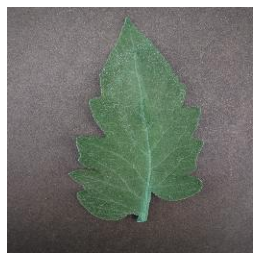

In [9]:
path = "plantvillage dataset/color/Tomato___healthy/0c8c9c80-b7e0-47a7-81d3-b5a2174e545d___GH_HL Leaf 496.1.JPG"
img = cv2.imread(path, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)
plt.tight_layout()
plt.axis("off")
plt.show()

(256, 256, 3)


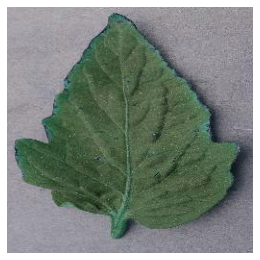

In [10]:
path = "plantvillage dataset/color/Tomato___Bacterial_spot/12e9560a-01a5-4d97-a911-409c11cd0301___GCREC_Bact.Sp 3117.JPG"
img = cv2.imread(path, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)
plt.tight_layout()
plt.axis("off")
plt.show()

## color

In [3]:
classes = ["healthy", "infected"]
color = glob.glob("plantvillage dataset/color/**/*.*")
np.random.shuffle(color)
len(color), color[:10]

(54305,
 ['plantvillage dataset/color/Grape___Black_rot/11f66442-5612-499c-a0a1-77f8c3668234___FAM_B.Rot 0727.JPG',
  'plantvillage dataset/color/Potato___Early_blight/cceeec9d-e0d9-4512-a1f0-faa5dc6bbf40___RS_Early.B 8381.JPG',
  'plantvillage dataset/color/Grape___Esca_(Black_Measles)/cc0cffcf-3a33-4ba5-a4b8-6b5a4dfc4689___FAM_B.Msls 4380.JPG',
  'plantvillage dataset/color/Tomato___Septoria_leaf_spot/f04c7577-d02a-4b57-861e-f50fa800ca85___Matt.S_CG 7787.JPG',
  'plantvillage dataset/color/Tomato___Leaf_Mold/705249ab-9023-4025-8f6c-9ed74b1b69d9___Crnl_L.Mold 7014.JPG',
  'plantvillage dataset/color/Orange___Haunglongbing_(Citrus_greening)/f6c1210b-b50f-4a1e-bb80-1bdb3181bf68___UF.Citrus_HLB_Lab 0935.JPG',
  'plantvillage dataset/color/Orange___Haunglongbing_(Citrus_greening)/c1bb681d-9c6a-46ce-909a-7495abfcf6e8___CREC_HLB 4694.JPG',
  'plantvillage dataset/color/Potato___Late_blight/b2492a9e-c038-48a7-8524-8f0aca7dc870___RS_LB 4291.JPG',
  'plantvillage dataset/color/Tomato___healthy

In [4]:
split = int(len(color) * 0.8)
train_path = color[:split]
test_path = color[split:]
len(color), len(train_path), len(test_path)

(54305, 43444, 10861)

# train

In [29]:
class PlantDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform):
        self.data_path = data_path
        self.transform = transform
        self.imgs = []
        self.targets = []

        for d in self.data_path:
            # img = Image.open(d)
            # img = np.array(img.convert("RGB"))
            # if self.transform:
            #     img = self.transform(img)
            # self.imgs.append(img)

            p1 = d.split("___", 1)[1]
            if p1.split("/", 1)[0] == "healthy":
                self.targets.append(0)
            else:
                self.targets.append(1)
        
        # self.imgs = np.array(all_color_images)
        self.targets = np.array(self.targets)

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        img = Image.open(self.data_path[idx])
        img = np.array(img.convert("RGB"))
        if self.transform:
           img = self.transform(img)
        
        return img, self.targets[idx]

In [41]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        
        _, preds = torch.max(output, 1)
        loss = criterion(output, target)
        
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % 70 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch + 1, 
                    batch_idx * len(data), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), 
                    loss.item()
                )
            )
    
    return running_loss / batch_idx

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = torch.zeros(len(classes), len(classes))
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device)
            output = model(data)

            _, preds = torch.max(output, 1)
            for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            test_loss += criterion(output, target).item()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, 
            correct, 
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        )
    )
    
    return correct / len(test_loader.dataset), confusion_matrix

## our model

In [27]:
class Net(nn.Module):
    def __init__(self, out_size):
        super(Net, self).__init__()
        self.out_size = out_size

        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        self.conv3 = nn.Conv2d(32, 48, 5, 1)
        self.conv4 = nn.Conv2d(48, 64, 5, 1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 28 * 28, 32 * 8 * 8) # 50.176 x 2.048
        self.fc2 = nn.Linear(32 * 8 * 8, 1024)         #  2.048 x 1024
        self.fc3 = nn.Linear(1024, out_size)           #   1024 x 2
    
    def forward(self, x):
        # x -> [batch_size, channel, width, height]
        # x -> [128, 3, 256, 256]
        
        x = self.relu(self.conv1(x)) # x -> [128, 16, 254, 254]
        x = self.relu(self.conv2(x)) # x -> [128, 32, 250, 250]
        x = self.pool(x)             # x -> [128, 32, 125, 125]
        x = self.relu(self.conv3(x)) # x -> [128, 48, 121, 121]
        x = self.pool(x)             # x -> [128, 48,  60,  60]
        x = self.relu(self.conv4(x)) # x -> [128, 64,  56,  56]
        x = self.pool(x)             # x -> [128, 64,  28,  28]
        
        x = torch.flatten(x, 1)      # x -> [128, 64 * 28 * 28]
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


Test set: Average loss: 0.0054, Accuracy: 2980/10861 (27%)

Train Epoch: 1 [0/43444 (0%)]	Loss: 0.697209
Train Epoch: 1 [8960/43444 (21%)]	Loss: 0.448247
Train Epoch: 1 [17920/43444 (41%)]	Loss: 0.188988
Train Epoch: 1 [26880/43444 (62%)]	Loss: 0.122707
Train Epoch: 1 [35840/43444 (83%)]	Loss: 0.170428

Test set: Average loss: 0.0009, Accuracy: 10319/10861 (95%)

Train Epoch: 2 [0/43444 (0%)]	Loss: 0.102146
Train Epoch: 2 [8960/43444 (21%)]	Loss: 0.044835
Train Epoch: 2 [17920/43444 (41%)]	Loss: 0.129202
Train Epoch: 2 [26880/43444 (62%)]	Loss: 0.127374
Train Epoch: 2 [35840/43444 (83%)]	Loss: 0.026181

Test set: Average loss: 0.0006, Accuracy: 10445/10861 (96%)

Train Epoch: 3 [0/43444 (0%)]	Loss: 0.092414
Train Epoch: 3 [8960/43444 (21%)]	Loss: 0.021140
Train Epoch: 3 [17920/43444 (41%)]	Loss: 0.033226
Train Epoch: 3 [26880/43444 (62%)]	Loss: 0.014823
Train Epoch: 3 [35840/43444 (83%)]	Loss: 0.071084

Test set: Average loss: 0.0003, Accuracy: 10610/10861 (98%)

Train Epoch: 4 [0/434

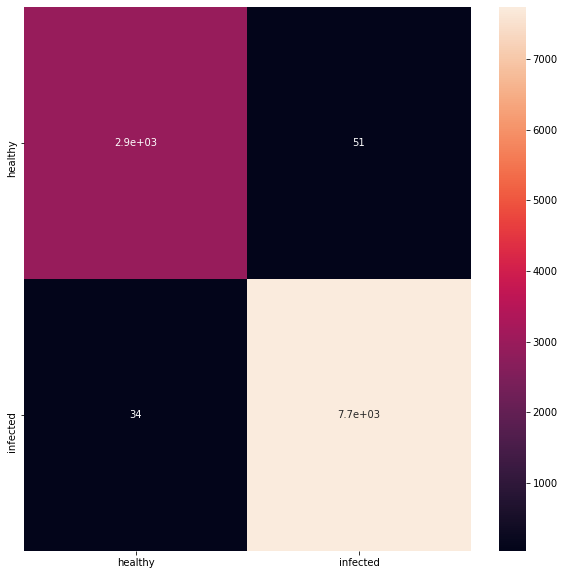

In [42]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = PlantDataset(train_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = PlantDataset(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(2).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

loss_values = []
accuracy_values = []
test(model, device, test_loader, criterion)
for epoch in range(5):
    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    loss_values.append(train_loss)

    test_acc, confusion_matrix = test(model, device, test_loader, criterion)
    accuracy_values.append(test_acc)

    scheduler.step()

torch.save(model.state_dict(), "plant_model.pth")

df_cm = pd.DataFrame(confusion_matrix.numpy(), index=classes, columns=classes)
plt.figure(figsize=(10, 10))
sns.heatmap(df_cm, annot=True)
plt.show()

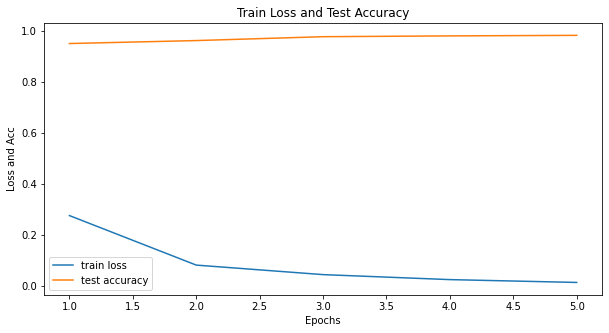

In [43]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, 6).astype(int), loss_values, label="train loss")
ax.plot(np.arange(1, 6).astype(int), accuracy_values, label="test accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss and Acc')
plt.title('Train Loss and Test Accuracy')
plt.legend()
plt.show()

In [44]:
summary(model, input_size=(3, 256, 256), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 16, 254, 254]             448
              ReLU-2        [128, 16, 254, 254]               0
            Conv2d-3        [128, 32, 250, 250]          12,832
              ReLU-4        [128, 32, 250, 250]               0
         MaxPool2d-5        [128, 32, 125, 125]               0
            Conv2d-6        [128, 48, 121, 121]          38,448
              ReLU-7        [128, 48, 121, 121]               0
         MaxPool2d-8          [128, 48, 60, 60]               0
            Conv2d-9          [128, 64, 56, 56]          76,864
             ReLU-10          [128, 64, 56, 56]               0
        MaxPool2d-11          [128, 64, 28, 28]               0
           Linear-12                [128, 2048]     102,762,496
             ReLU-13                [128, 2048]               0
          Dropout-14                [12

## transfer learning

param.requires_grad: layer4.1.conv2.weight
param.requires_grad: fc.weight
param.requires_grad: fc.bias

Test set: Average loss: 0.0057, Accuracy: 5214/10861 (48%)

Train Epoch: 1 [0/43444 (0%)]	Loss: 0.789341
Train Epoch: 1 [8960/43444 (21%)]	Loss: 0.048481
Train Epoch: 1 [17920/43444 (41%)]	Loss: 0.025774
Train Epoch: 1 [26880/43444 (62%)]	Loss: 0.043765
Train Epoch: 1 [35840/43444 (83%)]	Loss: 0.026566

Test set: Average loss: 0.0002, Accuracy: 10638/10861 (98%)

Train Epoch: 2 [0/43444 (0%)]	Loss: 0.015302
Train Epoch: 2 [8960/43444 (21%)]	Loss: 0.020730
Train Epoch: 2 [17920/43444 (41%)]	Loss: 0.014708
Train Epoch: 2 [26880/43444 (62%)]	Loss: 0.016998
Train Epoch: 2 [35840/43444 (83%)]	Loss: 0.023106

Test set: Average loss: 0.0002, Accuracy: 10682/10861 (98%)

Train Epoch: 3 [0/43444 (0%)]	Loss: 0.010253
Train Epoch: 3 [8960/43444 (21%)]	Loss: 0.002607
Train Epoch: 3 [17920/43444 (41%)]	Loss: 0.014186
Train Epoch: 3 [26880/43444 (62%)]	Loss: 0.004538
Train Epoch: 3 [35840/43444 (8

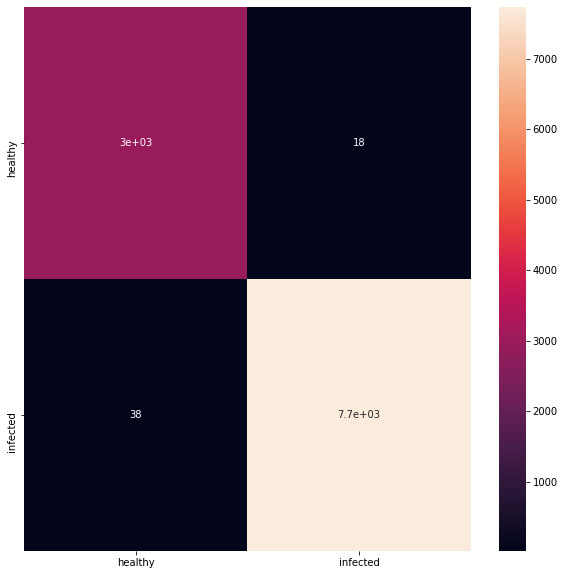

In [37]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = PlantDataset(train_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = PlantDataset(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model.layer4[1].conv2.weight.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print("param.requires_grad:", name)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

loss_values = []
accuracy_values = []
test(model, device, test_loader, criterion)
for epoch in range(5):
    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    loss_values.append(train_loss)

    test_acc, confusion_matrix = test(model, device, test_loader, criterion)
    accuracy_values.append(test_acc)

    scheduler.step()

torch.save(model.state_dict(), "scene_model.pth")

df_cm = pd.DataFrame(confusion_matrix.numpy(), index=classes, columns=classes)
plt.figure(figsize=(10, 10))
sns.heatmap(df_cm, annot=True)
plt.show()

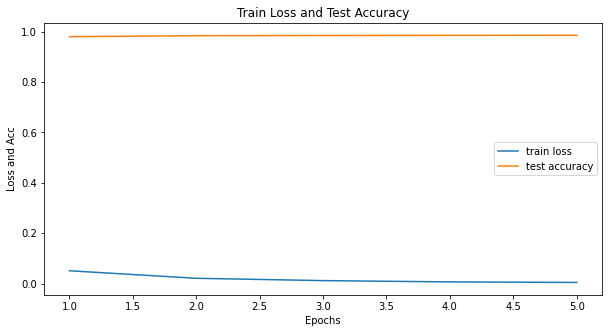

In [38]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, 6).astype(int), loss_values, label="train loss")
ax.plot(np.arange(1, 6).astype(int), accuracy_values, label="test accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss and Acc')
plt.title('Train Loss and Test Accuracy')
plt.legend()
plt.show()

In [39]:
summary(model, input_size=(3, 256, 256), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 128, 128]           9,408
       BatchNorm2d-2        [128, 64, 128, 128]             128
              ReLU-3        [128, 64, 128, 128]               0
         MaxPool2d-4          [128, 64, 64, 64]               0
            Conv2d-5          [128, 64, 64, 64]          36,864
       BatchNorm2d-6          [128, 64, 64, 64]             128
              ReLU-7          [128, 64, 64, 64]               0
            Conv2d-8          [128, 64, 64, 64]          36,864
       BatchNorm2d-9          [128, 64, 64, 64]             128
             ReLU-10          [128, 64, 64, 64]               0
       BasicBlock-11          [128, 64, 64, 64]               0
           Conv2d-12          [128, 64, 64, 64]          36,864
      BatchNorm2d-13          [128, 64, 64, 64]             128
             ReLU-14          [128, 64,